# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [122]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [123]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [124]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [125]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    #Combining both transformations with Compose
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    #Creating dataset
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    #Organizing dataset into batches when calling the dataloader. Tried with default num_workers first, but then the training losses did not converge. I increased it to 4, meaning 4 batches are loaded simulateously.
    dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 4)
    
    # TODO: Implement function and return a dataloader
    
    return dataset_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [126]:
# Define function hyperparameters

#I tried a very small batch size first, but found that the losses did not make sense. Seems to work fine for size 32 or higher
batch_size = 50
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

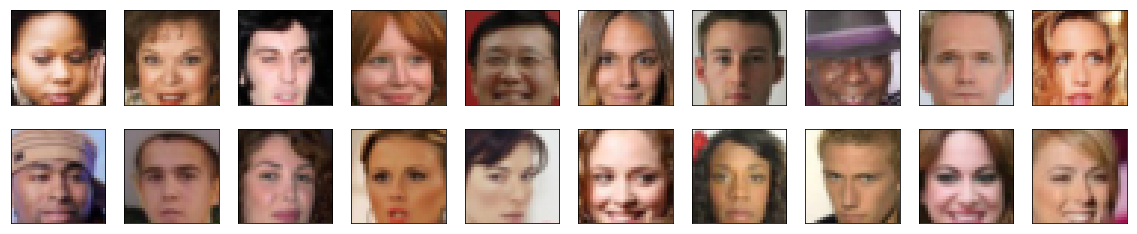

In [127]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [128]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    #standard scaling function as given in the lecture
    min, max = feature_range
    x = x*(max - min) + min
    
    
    return x


In [129]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9686)
Max:  tensor(0.9843)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [130]:
import torch.nn as nn
import torch.nn.functional as F

In [131]:
def convolutional(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    #create empty layer to fill. If it was already filled during a previous run, it would now be reset.
    appended_layer = []
    
    #call conv2d function with the specified parameters and save it as a variable. Default bias and batch normalization is set to false and true, respectively.
    convolutional_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    
    #For every function run, the layer is filled with the input from the Conv2D function
    appended_layer.append(convolutional_layer)
    
    #batch_norm only false for the first convolutional layer in the discriminator and the last one in the generator.
    #this function applies batch normalization to the correct convolutional layers.
    if batch_norm == True:
        appended_layer.append(nn.BatchNorm2d(out_channels))
        
    out_layers= nn.Sequential(*appended_layer)
        
    return out_layers

In [132]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        #standard initialization of parameters and convolutional layers.
        #I chose Leaky Relu 0.2 as given in the lecture/paper.
        #also, I added dropout which will will increase processing time but might prevent overfitting.
        #0.2 seemed like a reasonable intensity
        self.conv_dim = conv_dim
        self.Leaky_Relu = 0.2
        self.dropout = nn.Dropout(0.2)
        
        #Creating convolutional layers, starting from 3 color channels to conv_dim. No batch normalizaiton for the first layer.
        #Kernel size=, stride=2 and padding=1 means that the number of inputs will double after every convolution.
        #I tried applying a 4th convolutional layer to obtain more data, but this made matching output nodes to the linear layer quite messy.
        #Also, since the input image is only 32x32 pixels, the output dimension is 4x4 after the 3rd convolutional layer.
        #This means 3 layers is likely the limit for how many features can be extracted from a 32x32 px image.
        #A higher resolution image, for example 64x64 or 128x128, would allow a deeper convolutional network to get more data.
        
        self.conv1 = convolutional(3,conv_dim, batch_norm=False)
        self.conv2 = convolutional(conv_dim,conv_dim*2)
        self.conv3 = convolutional(conv_dim*2,conv_dim*4)
        #self.conv4 = convolutional(conv_dim*4,conv_dim*8)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)


        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        #standard forward pass with leaky relu activation function, followed by dropout
        output = F.leaky_relu(self.conv1(x), self.Leaky_Relu)
        
        output = self.dropout(output)
        output = F.leaky_relu(self.conv2(output), self.Leaky_Relu)
        
        output=self.dropout(output)
        output = F.leaky_relu(self.conv3(output), self.Leaky_Relu)
        
        #output=self.dropout(output)
        #output = F.leaky_relu(self.conv4(output), self.Leaky_Relu)
        
        #flatteing output before passing to fully connected layer
        output = output.view(-1, self.conv_dim*4*4*4)

        out = self.fc(output)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [133]:
def deconvolutional(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    
    #essentially the same as the convolution function, just with a transpose convolution function to reduce number of features
    
    appended_layer = []
    
    deconvolutional_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False)
    
    appended_layer.append(deconvolutional_layer)
    
    if batch_norm == True:
        appended_layer.append(nn.BatchNorm2d(out_channels))
        
    out_layers= nn.Sequential(*appended_layer)
        
    return out_layers

In [134]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        #same as the discriminator function, just in reverse. Nothing special to note here.
        self.conv_dim = conv_dim
        self.Leaky_Relu = 0.2
        self.dropout = nn.Dropout(0.2)
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        #self.deconv4 = deconvolutional(conv_dim*8, conv_dim*4)
        self.deconv3 = deconvolutional(conv_dim*4, conv_dim*2)
        self.deconv2 = deconvolutional(conv_dim*2, conv_dim)
        self.deconv1 = deconvolutional(conv_dim, 3, batch_norm=False)

        # complete init function
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        #Since the discriminator ended with a fully connected layer, we have ensure that the generator also has one
        #input vector is flattened
        x = self.fc(x)
        batch_size = x.shape[0]
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        #same forward pass as the discriminator, followed by a final tanh activation function
        
        #output = F.leaky_relu(self.deconv4(x), self.Leaky_Relu)
        
        #output = self.dropout(output)
        output = F.leaky_relu(self.deconv3(x), self.Leaky_Relu)
        
        output = self.dropout(output)
        output = F.leaky_relu(self.deconv2(output), self.Leaky_Relu)
        
        output = self.dropout(output)
        output = self.deconv1(output)
        
        output = torch.tanh(output)
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [135]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    #for every run of weights_init_normal, the function saves the class name (type) of the vector
    #the function below finds the vectors that correspond to convolutional layers and linera layers, then normalizes their inital weights.
    if classname.find('Convo2d') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [136]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [137]:
# Define model hyperparams
#Initial dimensions for the generator and discriminator should correspond to the image size, i.e 32x32 pixels

d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (dropout): Dropout(p=0.2)
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32,

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [138]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [139]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
   
    #Decided to stick with binary cross entropy loss and the functions for ground truth target from the course lecture.
    #If it ain't broken, don't fix it right?
    #BCE with logits loss includes sigmoid activation function, which saves me the trouble of manually inserting an activation function.
    
    size = D_out.size(0)
    
    #The target values are set to 0.9 if smooth. If they are real, they are set to 1.
    #Vector size is the same as the discriminator output.
    if smooth:
        target = torch.ones(size)*0.9
    else:
        target = torch.ones(size)
        
    #GPU training is always good to have, if you got the money for it.
    if train_on_gpu:
        target = target.cuda()
    
    #Obtaining loss value via the BCE loss function by comparing the output from D with the target (0.9 or 1)
    #The squeeze() operation removes all 1s from the tensor.
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), target)
    
    return loss

def fake_loss(D_out):
    
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    #Same as above. Creates a target vector with 0s of same size as the discriminator output vector.
    size = D_out.size(0)
    target = torch.zeros(size)
    
    #Cuda etc, yada yada.
    if train_on_gpu:
        target = target.cuda()
    
    #Calculates loss via BCE function by comparing output from D and the target (0s)
    #Squeeze() still removes 1s from D, which I guess prevents that the loss does not explode?
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), target)
    
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [140]:
import torch.optim as optim
#Used optimized values learning rate, exponential decays beta1 and beta2 as referenced in the paper
lr = 0.004
beta1 = 0.2
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1, beta2))

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [141]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            #___________START OF DISCRIMINATOR TRAINING___________#
            
            #Deleting previous gradients in the descriminator to prevent the exploding gradient issue.
            d_optimizer.zero_grad()

            #First, check if gpu can be used
            if train_on_gpu:
                real_images = real_images.cuda()
            
            #The discriminator will compare generated images with real images, so the real images must be the reference.
            #The loss function is applied to the D_real values, getting new loss values.
            #Here, the discriminator trains on real images
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            #Creating the input matrix z with dimensions corresponding to a given batch size and vector length z_size.
            #To make the training effective, the data in z is uniformly distributed between -1 and 1.
            #Finally, z is converted to a tensor with float datatype.
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            # GPU is nice
            if train_on_gpu:
                z = z.cuda()
            
            #Generator creates fake images based on the values from tensor z. These values are updated after every run.
            fake_images = G(z)
            
            
            #Discriminator trains on the fake images and checks their authenticity.
            #Saves the loss value from the training.
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            
            #Total loss is saved is saved as the sum of disriminator losses.
            #Weights and gradients in the discriminator are changed by backpropagation and the optimizer step, respectively.
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            #___________END OF DISCRIMINATOR TRAINING___________#
            
            #___________START OF GENERATOR TRAINING___________#

            #Gradients in the generator are deleted to prevent exploding gradients.
            g_optimizer.zero_grad()
            
            #A new matrix z is created with a uniform distribution of values between -1 and 1, like z for the discriminator.
            #Like before, z is converted from a numpy array to a tensor with floats.
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            #Applying GPU again, if applicable.
            if train_on_gpu:
                z = z.cuda()
            
            #Generate fake images by passing the z tensor through the generator.
            fake_images = G(z)
            
            #Get discriminator loss from fake images.
            #In other words, D_fake should increase because we want to fool the discriminator.
            D_fake = D(fake_images)
            
            #Label flipping, as used in the lecture.
            g_loss = real_loss(D_fake)
            
            #Updating weights and doing the optimization step
            g_loss.backward()
            g_optimizer.step()
            
            #___________END OF GENERATOR TRAINING___________#
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [142]:
## set number of epochs 
n_epochs = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.5182 | g_loss: 1.9982
Epoch [    1/   25] | d_loss: 1.5374 | g_loss: 0.6674
Epoch [    1/   25] | d_loss: 1.3911 | g_loss: 0.9835
Epoch [    1/   25] | d_loss: 1.3228 | g_loss: 0.8670
Epoch [    1/   25] | d_loss: 1.4232 | g_loss: 1.1780
Epoch [    1/   25] | d_loss: 1.3880 | g_loss: 0.9586
Epoch [    1/   25] | d_loss: 1.3053 | g_loss: 0.9086
Epoch [    1/   25] | d_loss: 1.5263 | g_loss: 1.3193
Epoch [    1/   25] | d_loss: 1.4049 | g_loss: 1.0932
Epoch [    1/   25] | d_loss: 1.2929 | g_loss: 1.1526
Epoch [    1/   25] | d_loss: 1.3790 | g_loss: 0.7335
Epoch [    1/   25] | d_loss: 1.3363 | g_loss: 0.8981
Epoch [    1/   25] | d_loss: 1.3602 | g_loss: 1.0046
Epoch [    1/   25] | d_loss: 1.3267 | g_loss: 0.6697
Epoch [    1/   25] | d_loss: 1.2618 | g_loss: 0.7452
Epoch [    1/   25] | d_loss: 1.3457 | g_loss: 0.8982
Epoch [    1/   25] | d_loss: 1.3433 | g_loss: 1.0709
Epoch [    1/   25] | d_loss: 1.2542 | g_loss: 0.6224
Epoch [    1/   25] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

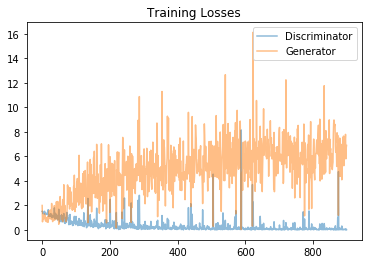

In [143]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [144]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [145]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

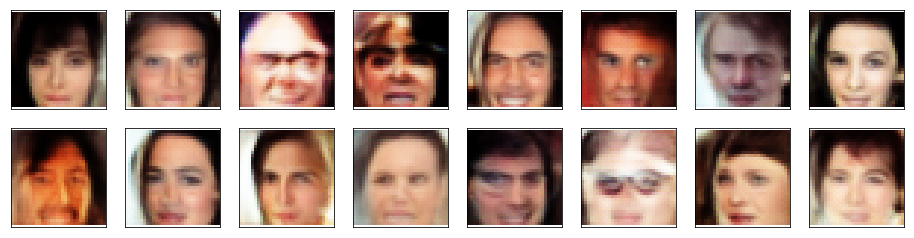

In [146]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**

#### Dataset

* As mentioned above, the dataset is biaset with a large number of images featuring white celebrities. As a result, most of my generated faces are white or slightly tanned. In order to successfully create fake images with more varied features, such as darker skin, it would be necessary to update the dataset with more varied images. In other words, train it to become less "racist".

#### Model size

* I only used 3 convolutional layers in the discriminator and generator because I wanted the training to be fast enough to get reasonable loss values within as few epochs as possible. Creating a deeper neural network with maybe 4-5 convolutional layers would allow more features to be extracted and combined in the generator. However, this would necessitate higher resolution images with 64x64 or 128x128 pixels, depending on the number of layers we want. This is the feature space the question refers to. Consequently, generating very high resolution fake images requires very deep convolutional GANS, and thus much computation power. Not to mention time.

#### Optimization strategy

* Obviously, allowing the model to train for more epochs would further improve accuracy and increase the quality of the generated images. Ultimately, the accuracy would be limited by the resolution of the dataset (feature space) and the depth of the model. My hyperparameters were very conservative in the beginning, with small learning rate lr=0.0002 and beta1=0.5 like in the paper. However, I noticed that I got less noise in the loss valuaes when slightly increasing learning rate and decreasing momentum.


* It should also be possible to improve the optimization by changing other starting parameters, such as the target values in the loss function and the initial weights. For example, one could change the standard deviation or the probability distribution type. Instead of Gaussian, one could use Cauchy. This would be highly experimental and likely not be a straightforward optimization, however.


* Alternatively, if the model could classify features in the dataset and label them accordingly, it would be easier to both train the model (detect correlation between neightboring pixels and tensors) as well as generating new faces based on selected labels.


* One thing to note is the noise observed in the loss value for both the generator and the discriminator. Specifically, we want the training losses for the discriminator to decrease and the generator to increase, but with as little noise/inconsistency as possible. Increasing the number of epochs can remidy this, but another solution might be to store or map the features that contribute to the noise, especially for the generator. These features can then be omitted (negative spike) or reused (positive spike) for the next image generation. It should be possible to filter out interesting features this way. If not the discriminator is racist, that is.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.